In [3]:
import pandas as pd
import sklearn
import itertools
import numpy as np
import seaborn as sb
import re
import nltk
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.linear_model import PassiveAggressiveClassifier
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [19]:
df = pd.read_csv('fake.csv/fake.csv')
df.head()

C:\Users\user\AppData\Local\Temp\ipykernel_15168\162193703.py:1: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('fake.csv/fake.csv')


,title,text,subject,date,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 163,Unnamed: 164,Unnamed: 165,Unnamed: 166,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,31-Dec-17,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,31-Dec-17,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,30-Dec-17,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,29-Dec-17,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,25-Dec-17,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [21]:
df.shape

(23502, 173)

In [23]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [25]:
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,31-Dec-17,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,31-Dec-17,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,30-Dec-17,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,29-Dec-17,0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,25-Dec-17,0


In [96]:
train_df = pd.read_csv('train.tsv', sep='\t', header=None)

train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [98]:
train_df.columns = [
'id','label','statement','subject','speaker','job',
'state','party',
'barely_true','false','half_true','mostly_true','pants_fire',
'context'
]

In [100]:
label_map = {
    'false': 0,
    'pants-fire': 0,
    'barely-true': 0,
    'half-true': 1,
    'mostly-true': 1,
    'true': 1
}

train_df['label'] = train_df['label'].map(label_map)

print(train_df['label'].value_counts())

label
1    5752
0    4488
Name: count, dtype: int64


In [104]:
print(train_df['label'].unique())

[0 1]


In [106]:
train_df = train_df.drop([
'id','subject','speaker','job','state','party',
'barely_true','false','half_true','mostly_true','pants_fire',
'context'
], axis=1)

In [110]:
train_df.shape

(10240, 2)

In [112]:
print(train_df.columns)

Index(['label', 'statement'], dtype='object')


In [114]:
train_df.head(15)

,label,statement
0,0,Says the Annies List political group supports ...
1,1,When did the decline of coal start? It started...
2,1,"Hillary Clinton agrees with John McCain ""by vo..."
3,0,Health care reform legislation is likely to ma...
4,1,The economic turnaround started at the end of ...
5,1,The Chicago Bears have had more starting quart...
6,0,Jim Dunnam has not lived in the district he re...
7,1,I'm the only person on this stage who has work...
8,1,"However, it took $19.5 million in Oregon Lotte..."
9,1,Says GOP primary opponents Glenn Grothman and ...


C:\Users\user\AppData\Local\Temp\ipykernel_15168\33152063.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  return sb.countplot(x='label', data=dataFile, palette='hls')


<Axes: xlabel='label', ylabel='count'>

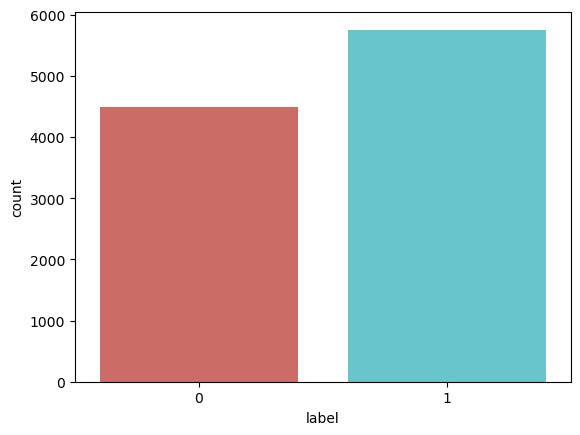

In [116]:
def create_distribution(dataFile):
    return sb.countplot(x='label', data=dataFile, palette='hls')

# by calling below we can see that training, test and valid data seems to be failry evenly distributed between the classes
create_distribution(train_df)

In [118]:
def data_qualityCheck():
    print("Checking data qualitites...")
    train_df.isnull().sum()
    train_df.info()  
    print("check finished.")
data_qualityCheck()

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      10240 non-null  int64 
 1   statement  10240 non-null  object
dtypes: int64(1), object(1)
memory usage: 160.1+ KB
check finished.


In [120]:
train_df = train_df.dropna()

In [122]:
data_qualityCheck()

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      10240 non-null  int64 
 1   statement  10240 non-null  object
dtypes: int64(1), object(1)
memory usage: 160.1+ KB
check finished.


In [124]:
train_df.shape

(10240, 2)

In [126]:
train_df.head(10)

,label,statement
0,0,Says the Annies List political group supports ...
1,1,When did the decline of coal start? It started...
2,1,"Hillary Clinton agrees with John McCain ""by vo..."
3,0,Health care reform legislation is likely to ma...
4,1,The economic turnaround started at the end of ...
5,1,The Chicago Bears have had more starting quart...
6,0,Jim Dunnam has not lived in the district he re...
7,1,I'm the only person on this stage who has work...
8,1,"However, it took $19.5 million in Oregon Lotte..."
9,1,Says GOP primary opponents Glenn Grothman and ...


In [128]:
train_df.reset_index(drop= True,inplace=True)

In [130]:
train_df.head(10)

,label,statement
0,0,Says the Annies List political group supports ...
1,1,When did the decline of coal start? It started...
2,1,"Hillary Clinton agrees with John McCain ""by vo..."
3,0,Health care reform legislation is likely to ma...
4,1,The economic turnaround started at the end of ...
5,1,The Chicago Bears have had more starting quart...
6,0,Jim Dunnam has not lived in the district he re...
7,1,I'm the only person on this stage who has work...
8,1,"However, it took $19.5 million in Oregon Lotte..."
9,1,Says GOP primary opponents Glenn Grothman and ...


In [132]:
label_train = train_df.label

In [134]:
label_train.head(10)

0    0
1    1
2    1
3    0
4    1
5    1
6    0
7    1
8    1
9    1
Name: label, dtype: int64

In [136]:
train_df = train_df.drop("label", axis = 1)

In [138]:
train_df.head(10)

,statement
0,Says the Annies List political group supports ...
1,When did the decline of coal start? It started...
2,"Hillary Clinton agrees with John McCain ""by vo..."
3,Health care reform legislation is likely to ma...
4,The economic turnaround started at the end of ...
5,The Chicago Bears have had more starting quart...
6,Jim Dunnam has not lived in the district he re...
7,I'm the only person on this stage who has work...
8,"However, it took $19.5 million in Oregon Lotte..."
9,Says GOP primary opponents Glenn Grothman and ...


In [142]:
train_df['statement'][2188]

'Says 94 percent of Wisconsin employers think the state is heading in the right direction and a majority say they will grow their companies in 2012.'

In [144]:
lemmatizer = WordNetLemmatizer()
stpwrds = list(stopwords.words('english'))

In [146]:
stpwrds

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [162]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')      # needed for proper lemmatization
nltk.download('punkt')        # needed for word_tokenize

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [166]:
for x in range(len(train_df)) :
    corpus = []
    review = train_df['statement'][x]
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = review.lower()
    review = nltk.word_tokenize(review)
    for y in review :
        if y not in stpwrds :
            corpus.append(lemmatizer.lemmatize(y))
    review = ' '.join(corpus)
    train_df['statement'][x] = review      

C:\Users\user\AppData\Local\Temp\ipykernel_15168\3506679626.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df['statement'][x] = review


In [171]:
train_df['statement'][2182]

'new york city murder'

In [177]:
X_train, X_test, Y_train, Y_test = train_test_split(train_df['statement'], label_train, test_size=0.3, random_state=1)

In [81]:
X_train

10140    comment fox news star megyn kelly finally reve...
11508    written daniel mcadams told attack iraq saddam...
4035     u representative california introduced bill bl...
4528     paris salah abdeslam thought direct participan...
2608     photo jorge lascar photo great wall china vasi...
                               ...                        
10955    daily caller progress unity found progress uni...
17289    archie elam third career transition living sta...
5192     philadelphia sometimes exhibition planned year...
12172    here something interesting unz review recipien...
235      changing montenegrin leader change ideology so...
Name: text, Length: 14532, dtype: object

In [179]:
X_train.shape

(7168,)

In [181]:
Y_train

3474    1
6202    0
5868    1
7357    0
9514    0
       ..
2895    0
7813    1
905     1
5192    1
235     0
Name: label, Length: 7168, dtype: int64

In [183]:
tfidf_v = TfidfVectorizer()
tfidf_X_train = tfidf_v.fit_transform(X_train)
tfidf_X_test = tfidf_v.transform(X_test)

In [185]:
tfidf_X_train.shape

(7168, 9108)

In [187]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [189]:
classifier = PassiveAggressiveClassifier()
classifier.fit(tfidf_X_train,Y_train)

PassiveAggressiveClassifier()

Accuracy: 54.88%
Confusion matrix, without normalization


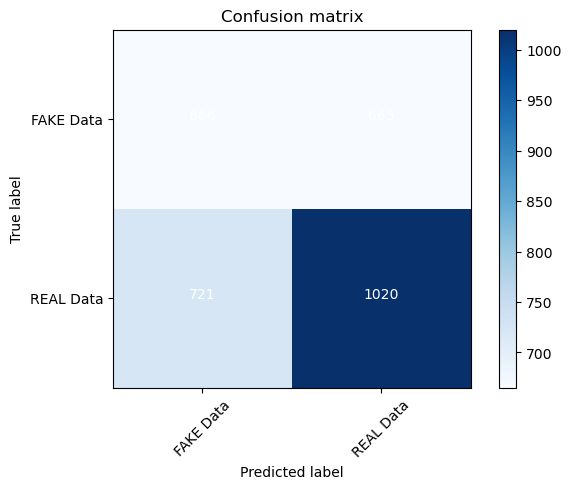

In [191]:
Y_pred = classifier.predict(tfidf_X_test)
score = metrics.accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {round(score*100,2)}%')
cm = metrics.confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

In [193]:
pickle.dump(classifier,open('./model.pkl', 'wb'))

In [195]:
# load the model from disk
loaded_model = pickle.load(open('./model.pkl', 'rb'))

In [203]:
def fake_news_det(news):
    review = news
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = review.lower()
    review = nltk.word_tokenize(review)
    for y in review :
        if y not in stpwrds :
            corpus.append(lemmatizer.lemmatize(y))     
    input_data = [' '.join(corpus)]
    vectorized_input_data = tfidf_v.transform(input_data)
    prediction = loaded_model.predict(vectorized_input_data)
    if prediction[0] == 0:
        print("Prediction of the News :  Looking Fake⚠ News📰 ")
    else:
        print("Prediction of the News : Looking Real News📰 ")